In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import total_harmonic_distortion, BLUE_COLOR, min_max_scale, fft, sinusoidal_voltages
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig
from matplotlib.colors import LogNorm

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"

### Parameter

In [10]:
AMPLITUDE_LIST  = [0.02]#,0.03,0.04,0.05,0.06,0.07,0.08]#,0.09,0.1]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_PARTICLES     = 9
PLOT_AMP_NORM   = Normalize(vmin=1000*AMPLITUDE_LIST[0], vmax=1000*AMPLITUDE_LIST[-1])

### Linear Time Constant and Frequency

In [4]:
topo    = {"Nx": N_PARTICLES,"Ny": N_PARTICLES,
           "e_pos": [[(N_PARTICLES-1)//2, 0],[0, 0],[N_PARTICLES-1, 0],
                     [0, (N_PARTICLES-1)//2],[N_PARTICLES-1, (N_PARTICLES-1)//2],
                     [0, N_PARTICLES-1],[N_PARTICLES-1, N_PARTICLES-1],[(N_PARTICLES-1)//2, N_PARTICLES-1]],
           "electrode_type": ['constant']*8}
sim_c   = Simulation(topo)
sim_c.build_conductance_matrix()
cap_m           = sim_c.get_capacitance_matrix()*1e-18
cap_e           = sim_c.get_electrode_capacitance_matrix().T*1e-18
g_m             = sim_c.get_conductance_matrix()
eigenvalues, _  = eig(g_m[:-8,:-8], cap_m)
real_eigs       = np.real(eigenvalues)
valid_eigs      = real_eigs[real_eigs > 1e-9]
lambda_min      = np.min(valid_eigs)
tau_t           = 1.0 / lambda_min
freq_t          = lambda_min / (2*np.pi)
print(f"f_r = {freq_t*1e-6}")
print(f"tau_0 = {tau_t*1e9}")

f_r = 49.82388564652937
tau_0 = 3.1943502805261783


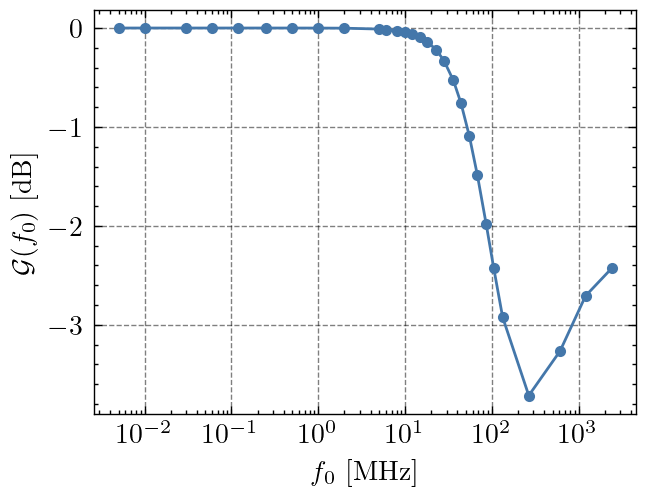

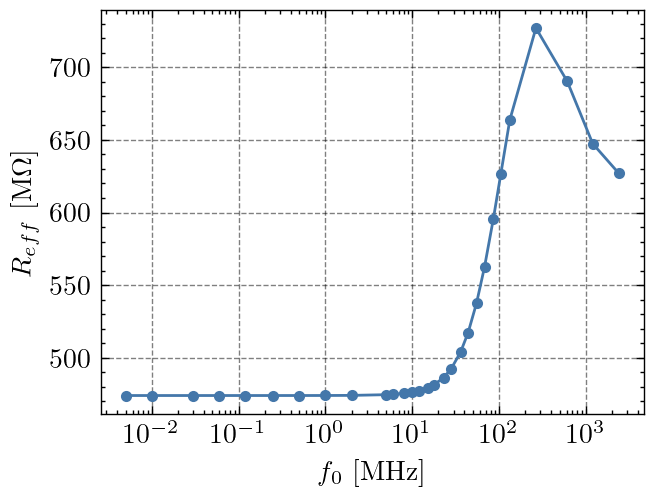

In [6]:
G_II    = g_m[:-8,:-8]
G_IE    = g_m[:-8,-8:]
Phi_E   = np.array([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],dtype=complex)
J_G     = - (G_IE @ Phi_E)

G_to_drain      = G_IE[:,-1]
C_to_drain      = cap_e[:,-1]

output_currents = []
for f in FREQ_LIST_MHZ:
    omega           = 2 * np.pi * f *1e6
    Y_system        = G_II + 1j * omega * cap_m   
    J_C             = - 1j * omega * (cap_e @ Phi_E)
    J_total         = J_G + J_C
    Phi_I           = np.linalg.solve(Y_system, J_total)
    # Y_to_drain      = G_to_drain + 1j * omega * C_to_drain
    I_out_complex   = np.dot(G_to_drain, Phi_I)
    output_currents.append(np.abs(I_out_complex))

output_currents = np.array(output_currents)
if output_currents[0] == 0:
    ref_val = np.max(output_currents)
else:
    ref_val = output_currents[0]
    
gains_db = 20 * np.log10(output_currents / ref_val)

fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, gains_db, '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(f_0)$ [dB]")

R_eff   = np.abs(Phi_E[0])/output_currents
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, R_eff*1e-6, '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$R_{eff}$ [M$\Omega$]")

### Load Data

In [11]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}_{amp:.3f}_constant.csv")
                  for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
state   = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}_{amp:.3f}_constant.csv")
                  for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
x = {amp : {freq : data[amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
y = {amp : {freq : data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
p = {amp : {freq : np.mean(state[amp][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

### Gain Curves

In [7]:
def gain_and_phase_current(n, N_periods=20):
    """
    Extracts magnitude and phase for the n-th harmonic.
    Assumes simulation contains exactly N_periods of the fundamental.
    """
    mags = {}
    phis = {}
    
    # Pre-calculate window (Blackman has great dynamic range for harmonics)
    # We assume all time series have the same length for a given f0? 
    # If length varies by freq, we must move this inside the loop.
    
    for amp in AMPLITUDE_LIST:
        mag_list = []
        phi_list = []
        
        for freq in FREQ_LIST_MHZ:
            # y_val = p[amp][freq]
            y_val = y[amp][freq]
            N_samples = len(y_val)
            
            # 1. Apply Window to suppress leakage from n=1 into n=11
            window = np.blackman(N_samples)
            y_windowed = y_val * window
            
            # Window Coherent Gain Correction (important for correct amplitude!)
            # For Blackman, this factor is approx 2.38, but calculating it is safer.
            w_gain = np.sum(window) / N_samples
            
            # 2. Compute FFT once
            fft_vals = np.fft.rfft(y_windowed)
            
            # 3. Find Exact Index
            # Since T_run = N_periods / f0, the bin spacing is f0 / N_periods.
            # The n-th harmonic is at n * f0.
            # Therefore, the index is exactly: n * N_periods
            k = n * N_periods
            
            # Safety check: ensure k is within the FFT array
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                
                # 4. Magnitude (Scaled and Corrected)
                # Mult by 2 for one-sided, divide by N, divide by window gain
                amplitude = (np.abs(Z_k) * 2 / N_samples) / w_gain
                mag_list.append(amplitude)
                
                # 5. Phase
                phi_list.append(np.angle(Z_k))
            else:
                # Harmonic is beyond the Nyquist frequency
                mag_list.append(np.nan)
                phi_list.append(np.nan)

        mags[amp] = np.array(mag_list)
        phis[amp] = np.array(phi_list)
        
    return mags, phis

def gain_and_phase_potential(n, N_periods=20):
    """
    Extracts magnitude and phase for the n-th harmonic.
    Assumes simulation contains exactly N_periods of the fundamental.
    """
    mags = {}
    phis = {}
    
    # Pre-calculate window (Blackman has great dynamic range for harmonics)
    # We assume all time series have the same length for a given f0? 
    # If length varies by freq, we must move this inside the loop.
    
    for amp in AMPLITUDE_LIST:
        mag_list = []
        phi_list = []
        
        for freq in FREQ_LIST_MHZ:
            y_val = p[amp][freq]
            # y_val = y[amp][freq]
            N_samples = len(y_val)
            
            # 1. Apply Window to suppress leakage from n=1 into n=11
            window = np.blackman(N_samples)
            y_windowed = y_val * window
            
            # Window Coherent Gain Correction (important for correct amplitude!)
            # For Blackman, this factor is approx 2.38, but calculating it is safer.
            w_gain = np.sum(window) / N_samples
            
            # 2. Compute FFT once
            fft_vals = np.fft.rfft(y_windowed)
            
            # 3. Find Exact Index
            # Since T_run = N_periods / f0, the bin spacing is f0 / N_periods.
            # The n-th harmonic is at n * f0.
            # Therefore, the index is exactly: n * N_periods
            k = n * N_periods
            
            # Safety check: ensure k is within the FFT array
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                
                # 4. Magnitude (Scaled and Corrected)
                # Mult by 2 for one-sided, divide by N, divide by window gain
                amplitude = (np.abs(Z_k) * 2 / N_samples) / w_gain
                mag_list.append(amplitude)
                
                # 5. Phase
                phi_list.append(np.angle(Z_k))
            else:
                # Harmonic is beyond the Nyquist frequency
                mag_list.append(np.nan)
                phi_list.append(np.nan)

        mags[amp] = np.array(mag_list)
        phis[amp] = np.array(phi_list)
        
    return mags, phis

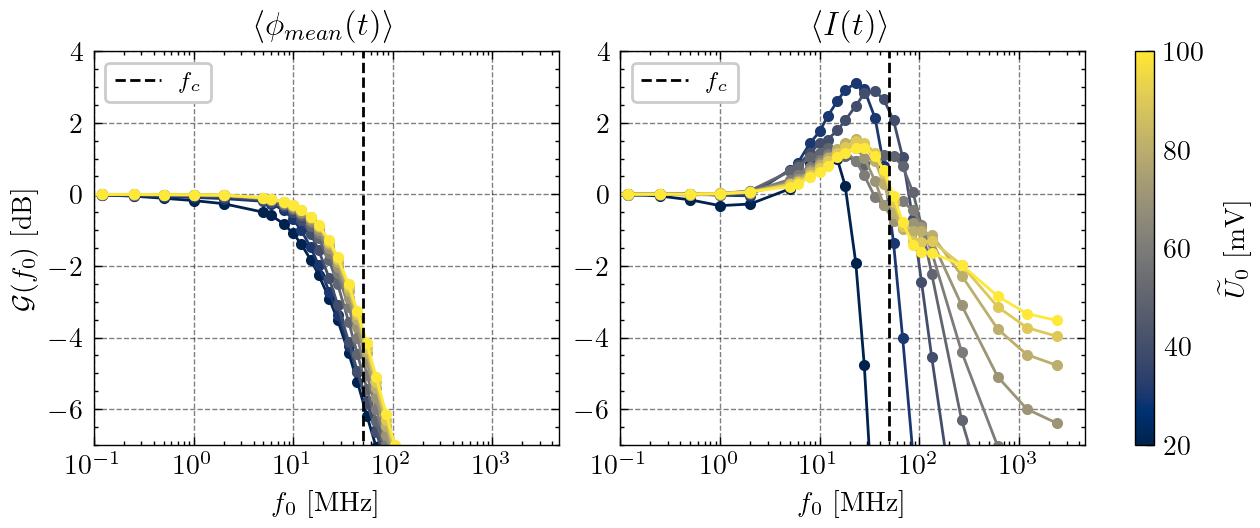

In [8]:
n       = 1
cmap    = plt.get_cmap('cividis')

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Potential
mags, phis  = gain_and_phase_potential(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

for amp in AMPLITUDE_LIST:
    ax1.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(PLOT_AMP_NORM(1000*amp)))
ax1.set_xscale('log')
_ = ax1.set_xlabel("$f_0$ [MHz]")
_ = ax1.set_ylabel("$\mathcal{G}(f_0)$ [dB]")
_ = ax1.vlines(freq_t*1e-6, -10, 5, color='black', ls='--', label="$f_c$")
_ = ax1.set_xlim(1e-1)
_ = ax1.set_ylim(-7,4)
_ = ax1.legend(fontsize='small', loc='upper left')
_ = ax1.set_title('$\\langle \phi_{mean}(t) \\rangle$')

# Current
mags, phis  = gain_and_phase_current(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

for amp in AMPLITUDE_LIST:
    ax2.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(PLOT_AMP_NORM(1000*amp)))
ax2.set_xscale('log')
_ = ax2.set_xlabel("$f_0$ [MHz]")
_ = ax2.vlines(freq_t*1e-6, -10, 5, color='black', ls='--', label="$f_c$")
_ = ax2.set_xlim(1e-1)
_ = ax2.set_ylim(-7,4)
_ = ax2.legend(fontsize='small', loc='upper left')
_ = ax2.set_title('$\\langle I(t) \\rangle$')

sm  = ScalarMappable(cmap=cmap, norm=PLOT_AMP_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1,ax2])
cbar.set_label("$\\widetilde{U}_0$ [mV]")

fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.png", transparent=False)

### Higher Harmonics

In [12]:
def compute_decay_alpha(amplitudes, harmonic_orders):
    """
    Calculates the Power Law Decay exponent (alpha) by fitting log(A) vs log(n).
    
    Parameters:
    - amplitudes: Array of magnitudes (must match len of harmonic_orders)
    - harmonic_orders: Array of n values (e.g. [1, 3, 5, 7])
    
    Returns:
    - alpha: The positive decay slope. Returns NaN if fit fails.
    """
    # We typically fit starting from the first harmonic or the third (n=3) 
    # depending on if you want to include the fundamental in the slope.
    # Ideally, filter for n >= 3 to see the "tail" decay.
    
    mask = (harmonic_orders >= 3)# & (amplitudes > 1e-15) # Filter noise/fundamental
    
    x = harmonic_orders[mask]
    y = amplitudes[mask]

    # x = harmonic_orders
    # y = amplitudes
    
    if len(x) < 2:
        return np.nan
        
    try:
        # Fit log(A) = -alpha * log(n) + C
        coeffs = np.polyfit(np.log(x), np.log(y), 1)
        return -coeffs[0] # Return positive alpha
    except:
        return np.nan
    
def compute_spectral_entropy(amplitudes):
    """
    Calculates Shannon Entropy of the normalized power spectrum.
    Input: Array of amplitudes.
    """
    power_spectrum = amplitudes**2
    total_power = np.sum(power_spectrum)
    
    if total_power == 0:
        return 0.0
        
    # Normalize to get probability distribution p_n
    p = power_spectrum / total_power
    
    # Filter out zeros to avoid log(0)
    p = p[p > 0]
    
    return -np.sum(p * np.log(p))

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

N_periods   = 20
n_vals      = np.arange(1,21,2)
print(n_vals)
amplitudes  = {}
for amp in AMPLITUDE_LIST:
    amps_tmp = []
    for freq in FREQ_LIST_MHZ:
        y_val       = y[amp][freq].copy()
        N_samples   = len(y_val)
        window      = np.blackman(N_samples)
        y_windowed  = y_val * window
        w_gain      = np.sum(window) / N_samples
        fft_vals    = np.fft.rfft(y_windowed)
        amps_tmp2   = []
        for n in n_vals:
            k = n * N_periods
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                mag = (np.abs(Z_k) * 2 / N_samples) / w_gain
                amps_tmp2.append(mag)
            else:
                amps_tmp2.append(0.0)
        amps_tmp2 = np.array(amps_tmp2)
        amps_tmp.append(amps_tmp2)
    amplitudes[amp] = amps_tmp
alphas  = {amp : [compute_decay_alpha(amplitudes[amp][i], n_vals) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
centr   = {amp : [compute_spectral_centroid(amplitudes[amp][i], n_vals) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
thds    = {amp : [compute_thd(amplitudes[amp][i]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

[ 1  3  5  7  9 11 13 15 17 19]


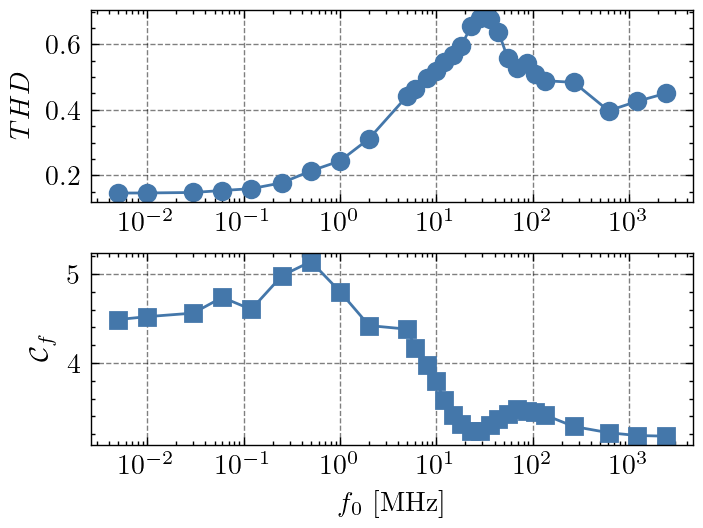

In [13]:
amp = 0.02
fig = plt.figure(dpi=200, layout='constrained')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
# for amp in AMPLITUDE_LIST:
ax1.plot(FREQ_LIST_MHZ, thds[amp], marker='o', label='$THD$')
ax2.plot(FREQ_LIST_MHZ, centr[amp], marker='s', label='$\\alpha$')
_ = ax1.set_ylabel("$THD$")
_ = ax2.set_ylabel("$\mathcal{C}_f$")
_ = ax2.set_xlabel("$f_0$ [MHz]")
ax1.set_xscale('log')
ax2.set_xscale('log')

fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_THD_alpha_vs_f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_THD_alpha_vs_f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_THD_alpha_vs_f0.png", transparent=False)

### Spatial Correlation

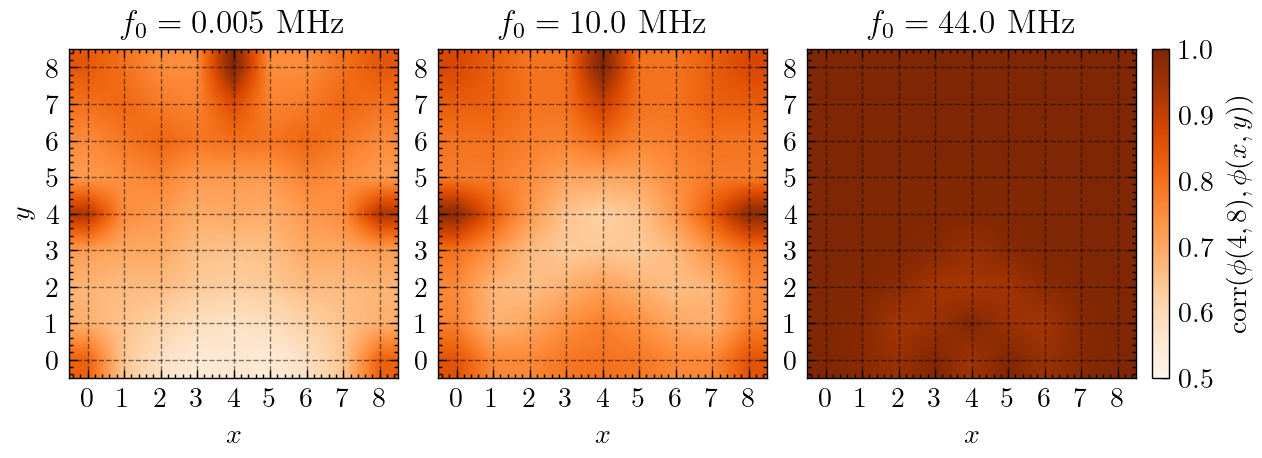

In [176]:
f0s      = [0.005, 10.0, 44.0]
np_idx   = -(N_PARTICLES//2)-1

fig = plt.figure(dpi=200,layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, f0 in enumerate(f0s):
    ax      = fig.add_subplot(1,3,i+1)
    arr     = state[0.02][f0].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values
    c_arr   = np.corrcoef(arr,rowvar=False)
    c_np    = c_arr[np_idx,:]
    im      = ax.imshow(c_np.reshape(N_PARTICLES,N_PARTICLES), cmap='Oranges', vmin=0.5, vmax=1, origin='lower', interpolation='bilinear')
    _       = ax.set_xticks(np.arange(N_PARTICLES))
    _       = ax.set_yticks(np.arange(N_PARTICLES))
    _       = ax.set_xlabel("$x$")
    _       = ax.set_title(f"$f_0 = {f0}$ MHz")
    if i == 0:
        _ = ax.set_ylabel("$y$") 

    if i == len(f0s) - 1:
        fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, label='$\\textrm{corr}(\phi(4,8),\phi(x,y))$')

fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_phi_vs_f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_phi_vs_f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_phi_vs_f0.png", transparent=False)

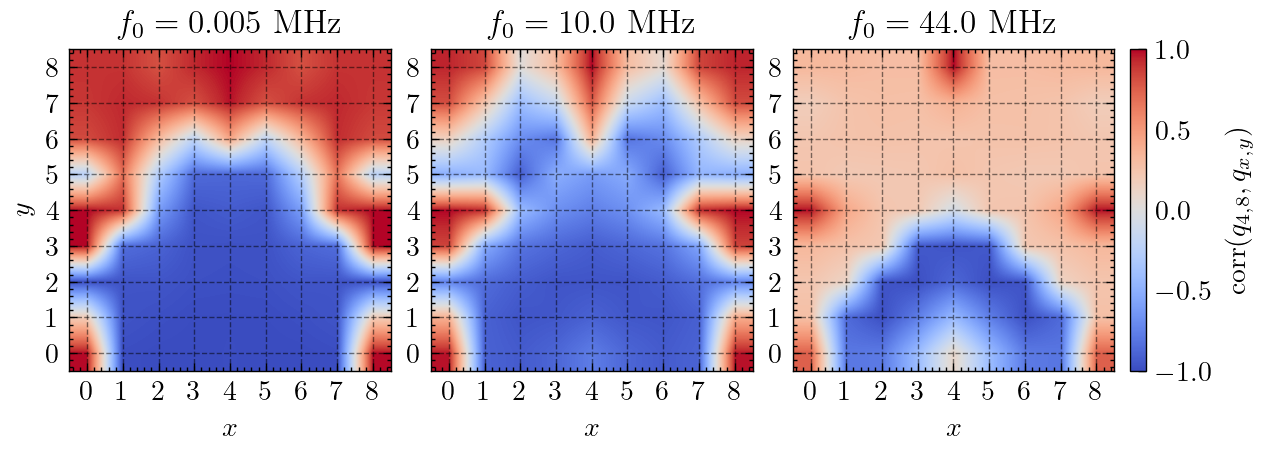

In [177]:
f0s      = [0.005, 10.0, 44.0]
np_idx   = -(N_PARTICLES//2)-1
# np_idx   = (N_PARTICLES**2)//2

fig = plt.figure(dpi=200,layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, f0 in enumerate(f0s):
    ax      = fig.add_subplot(1,3,i+1)
    arr     = state[0.02][f0].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values
    arr     = (cap_m @ arr.T).T
    c_arr   = np.corrcoef(arr,rowvar=False)
    c_np    = c_arr[np_idx,:]
    im      = ax.imshow(c_np.reshape(N_PARTICLES,N_PARTICLES), cmap='coolwarm', vmin=-1, vmax=1, origin='lower', interpolation='bilinear')
    _       = ax.set_xticks(np.arange(N_PARTICLES))
    _       = ax.set_yticks(np.arange(N_PARTICLES))
    _       = ax.set_xlabel("$x$")
    _       = ax.set_title(f"$f_0 = {f0}$ MHz")
    if i == 0:
        _ = ax.set_ylabel("$y$") 

    if i == len(f0s) - 1:
        fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, label='$\\textrm{corr}(q_{4,8},q_{x,y})$')

fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_q_vs_f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_q_vs_f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_spatial_corr_q_vs_f0.png", transparent=False)

In [211]:
# f0s      = [0.005, 10.0, 44.0]
# np_idx   = -(N_PARTICLES//2)-1

# fig = plt.figure(dpi=200,layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*1.8)
# for i, f0 in enumerate(f0s):

#     offsets = []
#     for v_val in x[0.02][f0]:
#         offsets.append(sim_c.get_charge_vector_offset(np.array([v_val,0,0,0,0,0,0,0,0])))

#     ax      = fig.add_subplot(1,3,i+1)
#     arr     = state[0.02][f0].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values
#     arr     = (cap_m @ arr.T).T - np.array(offsets)
#     c_arr   = np.corrcoef(arr,rowvar=False)
#     c_np    = c_arr[np_idx,:]
#     im      = ax.imshow(c_np.reshape(N_PARTICLES,N_PARTICLES), cmap='coolwarm', vmin=0, vmax=1, origin='lower', interpolation='bilinear')
#     _       = ax.set_xticks(np.arange(N_PARTICLES))
#     _       = ax.set_yticks(np.arange(N_PARTICLES))
#     _       = ax.set_xlabel("$x$")
#     _       = ax.set_title(f"$f_0 = {f0}$ MHz")
#     if i == 0:
#         _ = ax.set_ylabel("$y$") 

#     if i == len(f0s) - 1:
#         fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, label='$\\textrm{corr}(q_{4,8},q_{x,y})$')

### Frequency Spectrum

In [14]:
def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_windowed = signal * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

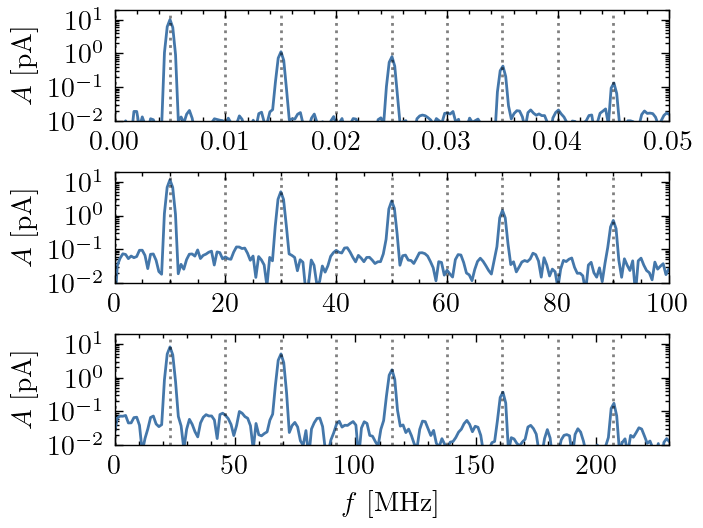

In [84]:
amp     = 0.02
f0_vals = [0.005,10.,23.]
fig     = plt.figure(dpi=200, layout='constrained')
for i, f0 in enumerate(f0_vals):
    y_val   = y[amp][f0]
    xf, yf  = get_frequency_spectrum(y_val,dts[f0])
    ax      = fig.add_subplot(len(f0_vals),1,i+1)
    _       = ax.semilogy(xf*1e-6, yf*1e-6)
    _       = ax.set_ylabel('$A$ [pA]')
    _       = ax.set_xlim(0,10*f0)
    _       = ax.set_ylim(0.01,20)
    ax.grid(False)
    for n in range(10):
        plt.axvline(n*f0, color='black', ls=':', alpha=0.5)
_ = ax.set_xlabel("$f$ [MHz]")

fig.savefig(f"plots/pdf/frequency_responses.pdf", transparent=False)
fig.savefig(f"plots/svg/frequency_responses.svg", transparent=True)
fig.savefig(f"plots/png/frequency_responses.png", transparent=False)

### Output Response

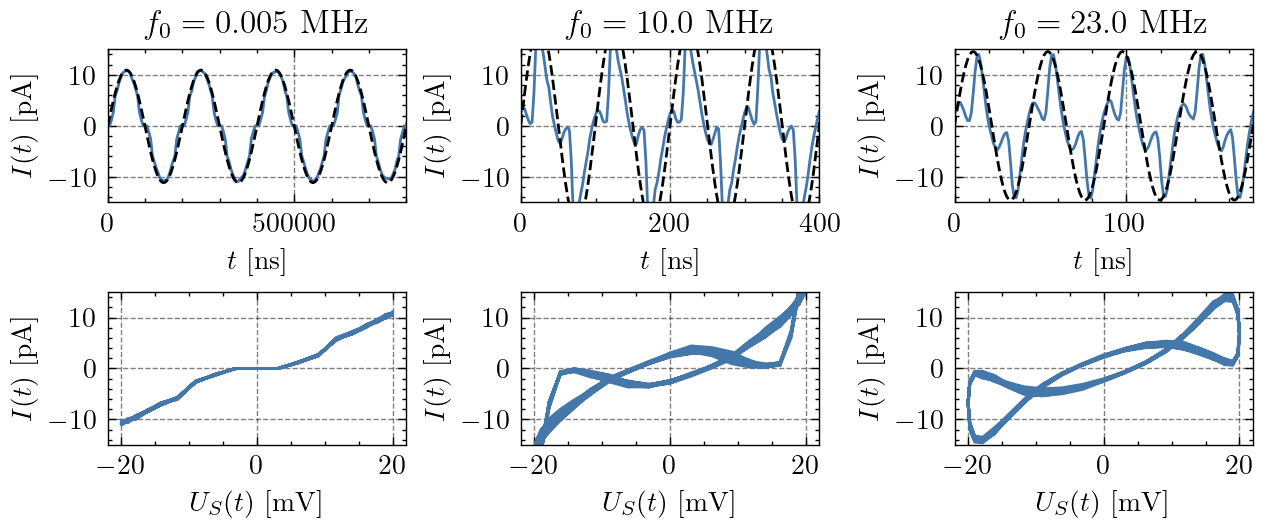

In [85]:
f0s = [0.005,10.,23.]
amp = 0.02
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, freq in enumerate(f0s):
    ax      = fig.add_subplot(2,3,i+1)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.plot(t_val*1e9, y_val)
    _       = ax.plot(t_val*1e9, (y_val.max() - y_val.min())*(x_val-x_val.min()) / (x_val.max() - x_val.min()) - y_val.max(), color='black', ls='--')
    _       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*4]*1e9)
    _       = ax.set_ylim(-15,15)
    _       = ax.set_xlabel("$t$ [ns]")
    _       = ax.set_ylabel("$I(t)$ [pA]")
    _       = ax.set_title(f"$f_0 = {freq}$ MHz")
for i, freq in enumerate(f0s):
    ax      = fig.add_subplot(2,3,i+4)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()*1000
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.set_ylim(-15,15)
    _       = ax.plot(x_val, y_val)
    _       = ax.set_xlabel("$U_S(t)$ [mV]")
    _       = ax.set_ylabel("$I(t)$ [pA]")

fig.savefig(f"plots/pdf/output_responses_examples.pdf", transparent=False)
fig.savefig(f"plots/svg/output_responses_examples.svg", transparent=True)
fig.savefig(f"plots/png/output_responses_examples.png", transparent=False)